<a href="https://colab.research.google.com/github/dataenthusiast092/InstanceSegmentationModel/blob/main/Instance_Segmentation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instance Segmentation Model

### Introduction to the Problem at hand

The problem involves training a deep learning model to perform instance segmentation on a video. Instance segmentation is a computer vision task that combines object detection and semantic segmentation. The goal is to identify and label each individual object instance within an image or video with a unique color. The requirement is to submit a video where each detected object instance is represented by a distinct color. A detailed document explaining the steps taken in the process is also necessary. While submitting code is optional, it's an option to showcase the implementation.



### What is the Key Concept behind the problem?

While Instance Segmentation is a technique that goes beyond object detection by not only identifying objects in an image but also segmenting them pixel by pixel and labeling each instance separately.

In [1]:
# !pip install tensorflow
# !pip install tensorflow-gpu
# !pip install torch torchvision
# !pip install opencv-python
# !pip install matplotlib scikit-learn
# !pip install kaggle

In [5]:
import tensorflow as tf
import torch
import torchvision
import cv2
import matplotlib.pyplot as plt
import sklearn
from google.colab import files
files.upload()
import os
import random
import shutil
import numpy as np

Saving kaggle.json to kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c data-science-bowl-2018
!apt-get install unzip
!unzip /content/data-science-bowl-2018.zip -d /content/data-science-bowl-2018

100% 357M/358M [00:04<00:00, 27.4MB/s]
100% 358M/358M [00:04<00:00, 88.1MB/s]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
Archive:  /content/data-science-bowl-2018.zip
  inflating: /content/data-science-bowl-2018/stage1_sample_submission.csv.zip  
  inflating: /content/data-science-bowl-2018/stage1_solution.csv.zip  
  inflating: /content/data-science-bowl-2018/stage1_test.zip  
  inflating: /content/data-science-bowl-2018/stage1_train.zip  
  inflating: /content/data-science-bowl-2018/stage1_train_labels.csv.zip  
  inflating: /content/data-science-bowl-2018/stage2_sample_submission_final.csv.zip  
  inflating: /content/data-science-bowl-2018/stage2_test_final.zip  


In [25]:
# !ls -l /content/data-science-bowl-2018/stage1_train | grep "^d" | wc -l

670


In [14]:
# !rm -r /content/data-science-bowl-2018/stage1_train
# !rm -r /content/data-science-bowl-2018/stage1_train_labels.csv
# !unzip /content/data-science-bowl-2018/stage1_train.zip -d /content/data-science-bowl-2018/stage1_train
# !unzip /content/data-science-bowl-2018/stage1_train_labels.csv.zip -d /content/data-science-bowl-2018/stage1_train_labels.csv
!rm -r /content/data-science-bowl-2018/stage1_train_random_samples

In [ ]:
# !apt-get install tree
# !tree /content/data-science-bowl-2018/stage1_train -L 2

In [17]:
# !pip install matplotlib opencv-python-headless


## Data Preparation

**Introduction to the Data**

This dataset contains a large number of segmented nuclei images. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence). The dataset is designed to challenge an algorithm's ability to generalize across these variations.

Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders:

images contains the image file.
masks contains the segmented masks of each nucleus. This folder is only included in the training set. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).
The second stage dataset will contain images from unseen experimental conditions. To deter hand labeling, it will also contain images that are ignored in scoring. The metric used to score this competition requires that your submissions are in run-length encoded format. Please see the evaluation page for details.

As with any human-annotated dataset, you may find various forms of errors in the data. You may manually correct errors you find in the training set. The dataset will not be updated/re-released unless it is determined that there are a large number of systematic errors. The masks of the stage 1 test set will be released with the release of the stage 2 test set.

1. /stage1_train/* - training set images (images and annotated masks)

2. /stage1_test/* - stage 1 test set images (images only, you are predicting the masks)

3. /stage2_test/* (released later) - stage 2 test set images (images only, you are predicting the masks)

4. **stage1_sample_submission.csv** - a submission file containing the ImageIds for which you must predict during stage 1

5. **stage2_sample_submission.csv (released later)** - a submission file containing the ImageIds for which you must predict during stage 2

6. **stage1_train_labels.csv** - a file showing the run-length encoded representation of the training images. This is provided as a convenience and is redundant with the mask image files.

### **Step 1: Preparing the Dataset**

**Gather a labelled dataset with images and instance masks:**

1. Data Inspection
2. Data Preprocessing
3. Handling Missing Annotations
4. Removing Outliers
5. Balancing Classes
6. Data Augmentation

**Split the dataset into training and validation sets:**

1. Data Splitting
2. Data Format Loading

#### Gathering a Labeled Dataset into Training & Validation Sets

**1. Data Inspection**

To-Do:

1. Select a representative subset of images and masks from the dataset.

2. Manually review these images and masks to identify major anomalies, such as misaligned annotations and potential data corruption.

3. Note any instances where annotations do not match the corresponding images.

4. Develop automated code to perform checks for missing images within the dataset.

5. Implement automated checks to detect discrepancies in dimensions between images and their corresponding masks.

6. Utilize code to generate summary statistics, including image sizes and class distributions, to gain insights into data quality.

7. Analyze the insights gained from manual and automated inspection to understand the dataset's characteristics and potential issues.

8. Combine the insights from both manual and automated inspection to make an initial assessment of the dataset's suitability for instance segmentation.

9. Ensure that both manual scrutiny and automated validation processes are thorough, covering potential inconsistencies, errors, or anomalies.

10. Based on the combined findings from manual and automated inspection, establish a robust foundation for subsequent data preprocessing and model training.

**To-Do 1: Select a representative subset of images and masks from the dataset.**

1. Random Sampling
2. Sample Size
3. Diverse Representation
4. Stratification
5. Visual Appeal
6. Balancing
7. Variability
8. Coding Considerations

ValueError: ignored

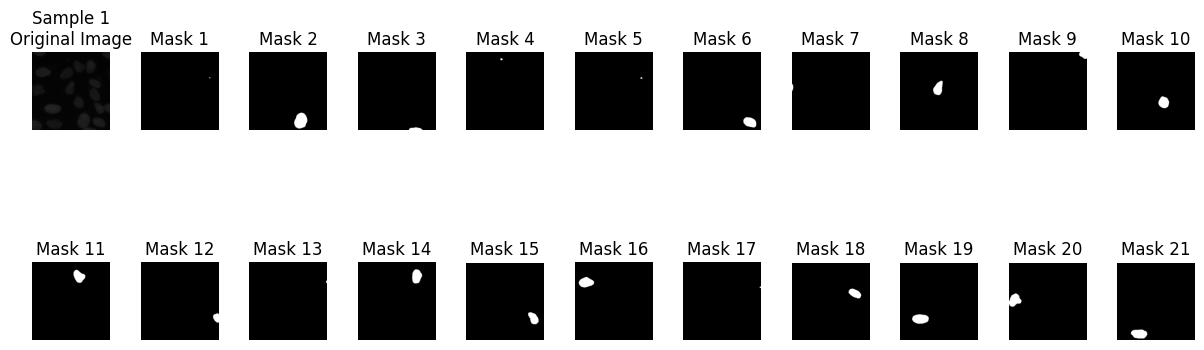

In [35]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# Set the paths
train_dataset_path = '/content/data-science-bowl-2018/stage1_train'
output_sample_size = 10  # Number of samples to select

# List all subdirectories (each representing an image)
image_dirs = [d for d in os.listdir(train_dataset_path) if os.path.isdir(os.path.join(train_dataset_path, d))]

# Randomly select a subset of samples
selected_samples = random.sample(image_dirs, output_sample_size)

# Set up the figure and subplot grid
num_cols = len(selected_samples) + 1
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.4)

# Iterate through the selected samples
for idx, sample in enumerate(selected_samples):
    # Paths to the image and mask folders
    image_folder = os.path.join(train_dataset_path, sample, 'images')
    mask_folder = os.path.join(train_dataset_path, sample, 'masks')

    # Get the image file
    image_filename = os.listdir(image_folder)[0]  # Assuming only one image per folder
    image_path = os.path.join(image_folder, image_filename)

    # Get a list of mask filenames
    mask_filenames = os.listdir(mask_folder)

    # Calculate the subplot index for the original image
    orig_img_subplot_idx = idx * num_cols + 1

    # Plot the original image
    plt.subplot(2, num_cols, orig_img_subplot_idx)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Sample {idx + 1}\nOriginal Image')
    plt.axis('off')

    # Plot each mask
    for mask_idx, mask_filename in enumerate(mask_filenames):
        mask_path = os.path.join(mask_folder, mask_filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Calculate the subplot index for each mask
        mask_subplot_idx = orig_img_subplot_idx + mask_idx + 1

        plt.subplot(2, num_cols, mask_subplot_idx)
        plt.imshow(mask, cmap='')
        plt.title(f'Mask {mask_idx + 1}')
        plt.axis('off')

plt.tight_layout()
plt.show()


**To-Do 2: Manually review these images and masks to identify major anomalies, such as misaligned annotations and potential data corruption.**

**To-Do 3: Note any instances where annotations do not match the corresponding images.**

**To-Do 4: Develop automated code to perform checks for missing images within the dataset.**

**To-Do 5: Implement automated checks to detect discrepancies in dimensions between images and their corresponding masks.**

**To-Do 6: Utilize code to generate summary statistics, including image sizes and class distributions, to gain insights into data quality.**

**To-Do 7: Analyze the insights gained from manual and automated inspection to understand the dataset's characteristics and potential issues.**

**To-Do 8: Combine the insights from both manual and automated inspection to make an initial assessment of the dataset's suitability for instance segmentation.**

**To-Do 9 : Ensure that both manual scrutiny and automated validation processes are thorough, covering potential inconsistencies, errors, or anomalies.**

**To-Do 10: Based on the combined findings from manual and automated inspection, establish a robust foundation for subsequent data preprocessing and model training.**

**2. Data preprocessing**

To-Do:

1. Alignment of Images and masks
2. Resizing Images and Masks
3. Normalization of Pixel Values
4. Handling Corrupted Images


**To-Do 1: Alignment of Images and masks**

**To-Do 2: Resizing Images and Masks**

**To-Do 3: Normalization of Pixel Values**

**To-Do 4: Handling Corrupted Images**

**3. Handling Missing Annotations**

To-Do:

1. Remove Images with Missing Annotations
2. Generate Synthetic Masks
  1. Interpolation
  2. Segmentation Algorithms
  3. Data Augmentation

  **Factors to choose approaches:** Dataset Size, Model Robustness, Task Complexity, Domain Expertise, etc.

**To-Do 1: Remove Images with Missing Annotations**

**To-Do 2: Generate Synthetic Masks**

1. Interpolation
2. Segmentation Algorithms
3. Data Augmentation

**4. Removing Outliers**

To-Do:

1. Visual Inspection
2. Anomaly Detection
3. Quantitative Analysis
4. Manual Verification
5. Correction or Removal
6. Documentation

**To-Do 1: Visual Inspection**

**To-Do 2: Anomaly Detection**

**To-Do 3: Quantitative Analysis**

**To-Do 4: Manual Verification**

**To-Do 5: Correction or Removal**

**To-Do 6: Documentation**

**5. Balancing Classes**

To-Do:

1. Data Augmentation
2. Oversampling
3. Undersampling
4. Synthetic Data Generation
5. Weighted loss Function
6. Ensemble Approaches

**Factors to choose approaches:** Balancing classes should be done while considering the impact on the overall dataset's quality and the performance of your instance segmentation model.

**To-Do 1: Data Augmentation**

**To-Do 2: Oversampling**

**To-Do 3: Undersampling**

**To-Do 4: Synthetic Data generation**

**To-Do 5: Weighted Loss Function**

**To-Do 6: Ensemble Approaches**

**6. Data Augmentation**

To-Do:

1. Images Augmentations
2. Mask Augmentations



**To-Do 1: Images Augmentation**

**To-Do 2: Mask Augmentations**

#### Splitting the Data into Training & Validation Sets

**Data Splitting:**

1. Shuffle the Dataset
2. Calculate Split Ratios
3. Allocate Data to Sets
4. Use Stratified Sampling
5. Data Usage
6. Maintain Consistency

**Data Formatting & Loading:**

1. COCO Format
2. Organizing the Data
3. JSON Annotations
4. Loading Data


**Data Splitting: Shuffle the Dataset**

**Data Splitting: Calculate Split Ratios**

**Data Splitting: Allocate Data to Sets**

**Data Splitting: Use Stratified Sampling**

**Data Splitting: Data Usage**

**Data Splitting: Maintain Consistency**

**Data Formatting & Loading: COCO Format**

**Data Formatting & Loading: Organizing the Data**

**Data Formatting & loading: JSON Annotations**

**Data Formatting & Loading: Finally Loading Data**

### Step 2: Choosing a Framework and Library

#### Framework: Use Tensorflow & Pytorch

#### Libraries: Utilize Tensorflow Object Detection API or Detectron2 for PyTorch

### Step 3: Select a Model Architecture

#### Choose from Architectures like Mask R-CNN, FCN or DeepLab

#### Pretrained Model: Use COCO pretrained models for a head start

### Step 4: Model Training

#### Fine-tune the chosen Model on your Dataset.

#### Adjust Hyperparameters, Learning Rate & Optimizer

#### Monitor Loss, Accuracy and Other Metrics during Training

### Step 5: Evaluation

#### Use a mean - Average Precision (mAP) to measure instance segmentation performance


#### Calculate Frame per second (FPS) to assess Inference Speed

### Step 6: Hardware Configuration for Inference

#### Specify the Hardware CPU / GPU used for Inferencing

#### Note the Memory & Processing Power